In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [2]:
# check if we have cuda installed
if torch.cuda.is_available():
    # to use GPU
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('GPU is:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
GPU is: NVIDIA GeForce RTX 4080 Laptop GPU


In [3]:
import pandas as pd
df = pd.read_csv('data/Corona_NLP_train.csv', encoding='ISO-8859-1')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector

In [5]:
def get_lang_detector(nlp, name):
    return LanguageDetector()

nlp = spacy.load("en_core_web_sm")
Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)

In [6]:
def detect_lan(text) :
    doc = nlp(text)
    detect_language = doc._.language 
    detect_language = detect_language['language']
    return(detect_language)

In [7]:
df['nation'] = df['OriginalTweet'].apply(lambda x: detect_lan(x))

In [8]:
dict(df.groupby('nation').count()['UserName'])

{'UNKNOWN': 14,
 'af': 11,
 'ca': 12,
 'cy': 2,
 'da': 5,
 'de': 25,
 'en': 40935,
 'es': 27,
 'et': 4,
 'fi': 2,
 'fr': 32,
 'id': 17,
 'it': 16,
 'nl': 9,
 'no': 14,
 'pl': 1,
 'pt': 4,
 'ro': 5,
 'sk': 2,
 'so': 1,
 'sv': 3,
 'sw': 2,
 'tl': 7,
 'tr': 5,
 'vi': 2}

In [9]:
# total number of english samples:
dict(df.groupby('nation').count()['UserName'])['en']
#### 40934 
# total number of non-english samples (exclude 'UNKNOWN')
sum([dict(df.groupby('nation').count()['UserName'])[x] for x in dict(df.groupby('nation').count()['UserName']).keys() if x not in ['en', 'UNKNOWN']])
##### 209

208

In [10]:
#filter the dataset to only english
filtered_df = df[df['nation'] == 'en']
filtered_df.to_csv('data/filtered_data.csv', index=True) # store all the en data into a new file
filtered_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,nation
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,en
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,en
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,en
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,en
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,en


In [11]:
dict(df.groupby('Sentiment').count()['UserName'])

{'Extremely Negative': 5481,
 'Extremely Positive': 6624,
 'Negative': 9917,
 'Neutral': 7713,
 'Positive': 11422}

In [12]:
import re
import string
def clean_text(text):
    # to lower case
    text = text.lower()
    # remove links
    text = re.sub('https:\/\/\S+', '', text) 
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) 
    # remove next line     
    text = re.sub(r'[^ \w\.]', '', text) 
    # remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)
    
    return text
# Create a new column called "Text" for collecting clean text
df['Text'] = df.OriginalTweet.apply(lambda x: clean_text(x))

In [13]:
df.Text.values[0]

'menyrbie philgahan chrisitv  and  and '

In [14]:
# load tokens
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
# Add words into token 
tokenizer.add_tokens(['covid', 'coronavirus'])

C:\Users\17456\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2

In [15]:
print(tokenizer.tokenize('covid'))
print(tokenizer.tokenize('coronavirus'))
# ['covid']
# ['coronavirus']

['covid']
['coronavirus']


In [16]:
# print first text
df.Text.values[0]

print({x : tokenizer.encode(x, add_special_tokens=False) for x in df.Text.values[0].split()})

{'menyrbie': [24850, 30291, 13], 'philgahan': [44171, 19284, 1121], 'chrisitv': [17656, 2726, 8283], 'and': [136]}


In [17]:
tokenizer(df.Text.values[0])['input_ids']


[0, 24850, 30291, 13, 44171, 19284, 1121, 17656, 2726, 8283, 136, 136, 2]

max:  93
min:  2


(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.]),
 [Text(0, 0.0, '0'),
  Text(0, 2000.0, '2000'),
  Text(0, 4000.0, '4000'),
  Text(0, 6000.0, '6000'),
  Text(0, 8000.0, '8000'),
  Text(0, 10000.0, '10000'),
  Text(0, 12000.0, '12000')])

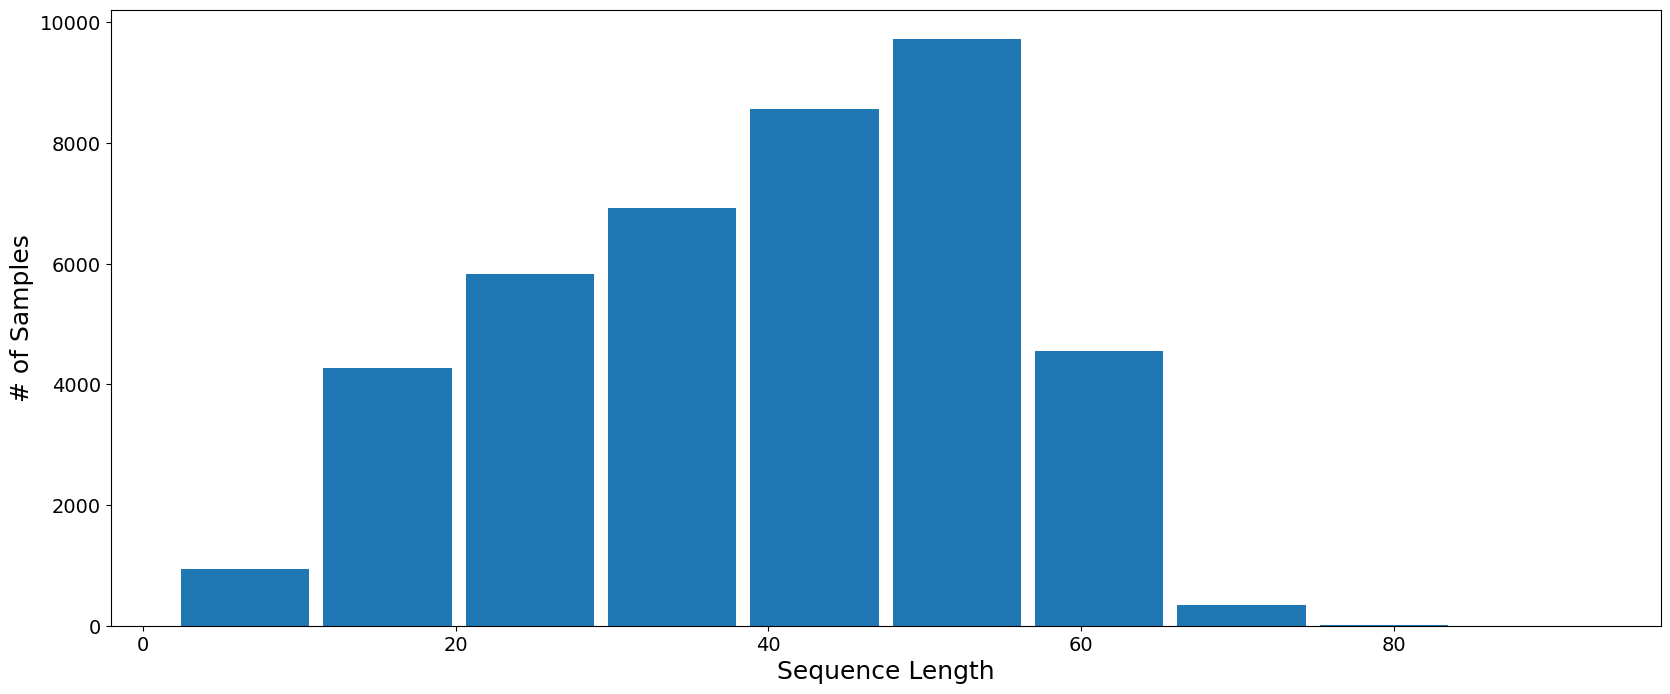

In [18]:
tokenized_feature_raw = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            df.Text.values.tolist(), 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True      
                   )
# collect tokenized sentence length 
token_sentence_length = [len(x) for x in tokenized_feature_raw['input_ids']]
print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))
# plot the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.hist(token_sentence_length, rwidth = 0.9)
plt.xlabel('Sequence Length', fontsize = 18)
plt.ylabel('# of Samples', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

In [19]:
features = df.Text.values.tolist()
target = df.Sentiment.values.tolist()

In [20]:
# tokenize features 
MAX_LEN = 128
tokenized_feature = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            features, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            # Add empty tokens if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Truncate all sentences to max length
                            truncation=True,
                            # Set the maximum length
                            max_length = MAX_LEN, 
                            # Return attention mask
                            return_attention_mask = True,
                            # Return pytorch tensors
                            return_tensors = 'pt'       
                   )

In [21]:
# convert label into numeric 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(target)
target_num = le.transform(target)

In [22]:
target_num
# output - array([3, 4, 4, ..., 4, 3, 2])

array([3, 4, 4, ..., 4, 3, 2])

In [23]:
# Use 80% for training and 20% for validation
from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(tokenized_feature['input_ids'], target_num,tokenized_feature['attention_mask'],random_state=2018, test_size=0.2, stratify=target)

In [24]:
# define batch_size
batch_size = 32
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# Create the DataLoader for our test set
validation_data = TensorDataset(validation_inputs, validation_masks, torch.tensor(validation_labels))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [25]:
# BertForSequenceClassification
from transformers import XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", 
    # Specify number of classes
    num_labels = len(set(target)), 
    # Whether the model returns attentions weights
    output_attentions = False,
    # Whether the model returns all hidden-states 
    output_hidden_states = False
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# Receive the full size of the new word
model.resize_token_embeddings(len(tokenizer))

Embedding(250004, 768)

In [27]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

In [28]:
# Number of training epochs
epochs = 1
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [29]:
# tell pytorch to run this model on GPU
model.cuda()

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250004, 768)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
   

In [30]:
# Training
import time
# Store the average loss after each epoch 
loss_values = []
# number of total steps for each epoch
print('total steps per epoch: ',  len(train_dataloader) / batch_size)
# looping over epochs
for epoch_i in range(0, epochs):
    
    print('training on epoch: ', epoch_i)
    # set start time 
    t0 = time.time()
    # reset total loss
    total_loss = 0
    # model in training 
    model.train()
    # loop through batch 
    for step, batch in enumerate(train_dataloader):
        # Progress update every 50 step 
        if step % 50 == 0 and not step == 0:
            print('training on step: ', step)
            print('total time used is: {0:.2f} s'.format(time.time() - t0))
        # load data from dataloader 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_labels = b_labels.long()# new add
        # clear any previously calculated gradients 
        model.zero_grad()
        # get outputs
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        # get loss
        loss = outputs[0]

        loss.backward()# new add

        # total loss
        total_loss += loss.item()
        # clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update optimizer
        optimizer.step()
        # update learning rate 
        scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("average training loss: {0:.2f}".format(avg_train_loss))

total steps per epoch:  32.15625
training on epoch:  0
training on step:  50
total time used is: 13.60 s
training on step:  100
total time used is: 25.80 s
training on step:  150
total time used is: 38.16 s
training on step:  200
total time used is: 50.70 s
training on step:  250
total time used is: 62.76 s
training on step:  300
total time used is: 75.07 s
training on step:  350
total time used is: 87.16 s
training on step:  400
total time used is: 99.20 s
training on step:  450
total time used is: 111.22 s
training on step:  500
total time used is: 123.64 s
training on step:  550
total time used is: 135.90 s
training on step:  600
total time used is: 149.03 s
training on step:  650
total time used is: 162.22 s
training on step:  700
total time used is: 174.72 s
training on step:  750
total time used is: 187.18 s
training on step:  800
total time used is: 199.25 s
training on step:  850
total time used is: 211.32 s
training on step:  900
total time used is: 223.40 s
training on step: 

In [31]:
# Test
import numpy as np
t0 = time.time()
# model in validation mode
model.eval()
# save prediction
predictions,true_labels =[],[]
# evaluate data for one epoch
for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # validation
    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)
    # get output
    logits = outputs[0]
    # move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    final_prediction = np.argmax(logits, axis=-1).flatten()
    predictions.append(final_prediction)
    true_labels.append(label_ids)
    
print('total time used is: {0:.2f} s'.format(time.time() - t0))

total time used is: 17.19 s


In [32]:
predictions 

[array([0, 0, 0, 0, 2, 0, 0, 3, 0, 1, 0, 0, 1, 4, 0, 0, 1, 0, 3, 2, 2, 0,
        3, 4, 0, 4, 1, 4, 0, 2, 4, 4], dtype=int64),
 array([4, 3, 4, 1, 2, 0, 4, 3, 1, 1, 4, 2, 2, 3, 1, 0, 4, 3, 4, 2, 4, 2,
        2, 4, 4, 2, 2, 0, 0, 2, 1, 1], dtype=int64),
 array([4, 4, 0, 4, 2, 0, 0, 2, 2, 3, 4, 2, 1, 2, 1, 4, 3, 0, 4, 0, 0, 1,
        0, 1, 2, 4, 1, 0, 4, 1, 1, 1], dtype=int64),
 array([4, 0, 4, 0, 3, 2, 2, 1, 3, 4, 3, 4, 2, 4, 4, 3, 4, 4, 0, 4, 3, 4,
        4, 0, 2, 1, 1, 2, 0, 4, 4, 4], dtype=int64),
 array([0, 2, 3, 3, 4, 1, 1, 4, 3, 0, 3, 2, 0, 3, 3, 1, 2, 1, 0, 4, 2, 4,
        2, 2, 3, 4, 3, 1, 0, 4, 4, 2], dtype=int64),
 array([4, 4, 1, 4, 2, 0, 2, 4, 4, 1, 2, 3, 3, 3, 3, 2, 1, 3, 4, 2, 0, 0,
        1, 2, 1, 2, 2, 2, 2, 0, 2, 1], dtype=int64),
 array([2, 1, 3, 3, 4, 3, 4, 2, 0, 1, 2, 4, 4, 0, 2, 4, 1, 4, 4, 1, 4, 1,
        0, 4, 0, 3, 0, 1, 4, 2, 2, 4], dtype=int64),
 array([1, 1, 4, 4, 4, 1, 2, 1, 1, 4, 1, 0, 3, 0, 4, 1, 2, 1, 3, 4, 1, 1,
        4, 2, 0, 2, 4, 2, 4, 2, 1, 3]

In [34]:
# convert numeric label to string
final_prediction_list = le.inverse_transform(np.concatenate(predictions))
final_truelabel_list = le.inverse_transform(np.concatenate(true_labels))

In [35]:
final_prediction_list


array(['Extremely Negative', 'Extremely Negative', 'Extremely Negative',
       ..., 'Extremely Positive', 'Negative', 'Negative'], dtype='<U18')

In [36]:
from sklearn.metrics import confusion_matrix, classification_report
cr = classification_report(final_truelabel_list, 
                           final_prediction_list, 
                           output_dict=False)
print(cr)

                    precision    recall  f1-score   support

Extremely Negative       0.63      0.86      0.73      1096
Extremely Positive       0.70      0.82      0.76      1325
          Negative       0.66      0.58      0.62      1983
           Neutral       0.82      0.72      0.77      1543
          Positive       0.68      0.61      0.64      2285

          accuracy                           0.69      8232
         macro avg       0.70      0.72      0.70      8232
      weighted avg       0.70      0.69      0.69      8232

